<h3>Capstone Project - The Battle of the Neighborhoods</h3>
<h4>Applied Data Science Capstone by IBM/Coursera</h4>
<h5>Table of contents</h5>
<h6>Introduction: Business Problem</h6>
Data
Methodology
Analysis
Results and Discussion
Conclusion
<h6>Introduction: Business Problem</h6>
<p>This project aims to select the safest borough in London based on the total crimes, explore the neighborhoods of that borough to find the 10 most common venues in each neighborhood and finally cluster the neighborhoods using k-mean clustering.</p>

<p>This report will be targeted to people who are looking to relocate to London. Inorder to finalise a neighborhood to hunt for an apartment, safety is considered as a top concern when moving to a new place. If you don’t feel safe in your own home, you’re not going to be able to enjoy living there. The crime statistics will provide an insight into this issue.</p>

<p>We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.</p>

<h6>Data</h6>
Based on definition of our problem, factors that will influence our decision are:

<p>The total number of crimes commited in each of the borough during the last year.
The most common venues in each of the neighborhood in the safest borough selected.
Following data sources will be needed to extract/generate the required information:

Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016: A dataset consisting of the crime statistics of each borough in London obtained from Kaggle
Part 2: Scraping additional information of the different Boroughs in London from a Wikipedia page.: More information regarding the boroughs of London is scraped using the Beautifulsoup library
Part 3: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.: Co-ordinate of neighborhood will be obtained using Google Maps API geocoding
Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016</p>

<h5>London Crime Data</h5>

<h6>About this file</h6>

<p>lsoa_code: code for Lower Super Output Area in Greater London.
<ol><li>borough: Common name for London borough.</li>
    <li>major_category: High level categorization of crime</li>
    <li>minor_category: Low level categorization of crime within major category.</li>
    <li>value: monthly reported count of categorical crime in given borough</li>
    <li>year: Year of reported counts, 2008-2016</li>
    <li>month: Month of reported counts, 1-12</li></ol></p>
Data set URL: https://www.kaggle.com/jboysen/london-crime

<h6>Import necessary libraries</h6>

In [28]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  
import lxml.html as lh

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


<h5>Define Foursquare Credentials and Version</h5>
Make sure that you have created a Foursquare developer account and have your credentials handy

In [4]:
CLIENT_ID = 'CLX5R3ZGYXQNS1NCHQTYYKUR0EIAAMN31FFE1GX5HELX4PTT' # your Foursquare ID
CLIENT_SECRET = 'QKJ4TUCALHDUUEVQITP3LLWD10BB4TGEL5FIKV2ANFZO5OFA' # your Foursquare Secret

VERSION = '20200417'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CLX5R3ZGYXQNS1NCHQTYYKUR0EIAAMN31FFE1GX5HELX4PTT
CLIENT_SECRET:QKJ4TUCALHDUUEVQITP3LLWD10BB4TGEL5FIKV2ANFZO5OFA


<h4> Read the Dataset</h4>

In [5]:
df = pd.read_csv("london_crime_by_lsoa.csv")

In [6]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0.0,2016.0,11.0
1,E01001646,Greenwich,Violence Against the Person,Other violence,0.0,2016.0,11.0
2,E01000677,Bromley,Violence Against the Person,Other violence,0.0,2015.0,5.0
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0.0,2016.0,3.0
4,E01004563,Wandsworth,Robbery,Personal Property,0.0,2008.0,6.0


<h4>Accessing the most recent crime rates (2016)</h4>

In [7]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [8]:
df.shape

(122931, 7)

In [9]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


<h4>Change the column name</h4>

In [10]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122931 entries, 0 to 122930
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LSOA_Code       122931 non-null  object 
 1   Borough         122931 non-null  object 
 2   Major_Category  122931 non-null  object 
 3   Minor_Category  122931 non-null  object 
 4   No_of_Crimes    122931 non-null  float64
 5   Year            122931 non-null  float64
 6   Month           122931 non-null  float64
dtypes: float64(3), object(4)
memory usage: 6.6+ MB


<h4>Total no. of crimes in each borough</h4>

In [12]:
df['Borough'].value_counts()

Lambeth                   5480
Southwark                 5213
Croydon                   5012
Newham                    4907
Tower Hamlets             4816
Ealing                    4743
Brent                     4688
Barnet                    4633
Lewisham                  4602
Hackney                   4447
Haringey                  4400
Enfield                   4279
Islington                 4161
Westminster               4146
Wandsworth                4136
Camden                    4019
Greenwich                 3994
Hillingdon                3914
Hounslow                  3859
Waltham Forest            3831
Bromley                   3700
Redbridge                 3637
Hammersmith and Fulham    3286
Havering                  3092
Barking and Dagenham      3067
Kensington and Chelsea    3037
Harrow                    2571
Merton                    2568
Bexley                    2560
Richmond upon Thames      2244
Sutton                    2131
Kingston upon Thames      1717
City of 

<h4>The total crimes per major category</h4>

In [13]:
df['Major_Category'].value_counts()

Theft and Handling             40360
Violence Against the Person    38591
Criminal Damage                15376
Burglary                       13545
Drugs                           6856
Robbery                         4610
Other Notifiable Offences       3593
Name: Major_Category, dtype: int64

<h4>Pivoting the table to view the no. of crimes for each major category in each Borough</h4>

In [14]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham          454             583   269   
Barnet                       1099             710   265   
Bexley                        355             523   223   
Brent                         800             709   651   
Bromley                       725             664   222   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       115     147               1773   
Barnet                                     147     137               3053   
Bexley                                      81      46               1415   
Brent                                      150     266               2952   
Bromley                                    121     117               2218   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        2007  
Barnet                                      2363  
Bexley                                      1401  
Brent                                       2796  
Bromley                                     2100

In [15]:
London_crime.reset_index(inplace = True)

In [16]:
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(33)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham          454             583   269   
1                               Barnet         1099             710   265   
2                               Bexley          355             523   223   
3                                Brent          800             709   651   
4                              Bromley          725             664   222   
5                               Camden          838             628   509   
6                       City of London            0               1     3   
7                              Croydon          825            1024   375   
8                               Ealing          789             811   392   
9                              Enfield          824             607   363   
10                           Greenwich          614             795   253   
11                             Hackney          835             624   445   
12              Hammersmith and Fulham          405             493   398   
13                            Haringey          730             678   441   
14                              Harrow          614             391   160   
15                            Havering          602             603   249   
16                          Hillingdon          731             745   330   
17                            Hounslow          577             696   365   
18                           Islington          692             631   553   
19              Kensington and Chelsea          443             311   567   
20                Kingston upon Thames          252             339   209   
21                             Lambeth          996             827   968   
22                            Lewisham          737             727   506   
23                              Merton          450             477   155   
24                              Newham          648             862   538   
25                           Redbridge          583             510   301   
26                Richmond upon Thames          410             410    89   
27                           Southwark          938             843   604   
28                              Sutton          400             417   160   
29                       Tower Hamlets          914             789   539   
30                      Waltham Forest          562             591   333   
31                          Wandsworth          710             610   260   
32                         Westminster          971             709   690   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    115     147               1773   
1                                    147     137               3053   
2                                     81      46               1415   
3                                    150     266               2952   
4                                    121     117               2218   
5                                    168     274               4399   
6                                      0       3                 40   
7                                    245     338               2822   
8                                    198     233               3121   
9                                    161     269               2538   
10                                   134     174               2482   
11                                   144     334               3727   
12                                   141     140               2917   
13                                   171     366               3307   
14                                    84     105               1346   
15                                   136      88               1877   
16                                   296     137         

<h4>Removing the multi index so that it will be easier to merge</h4>

In [17]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,454,583,269,115,147,1773,2007,5348
1,Barnet,1099,710,265,147,137,3053,2363,7774
2,Bexley,355,523,223,81,46,1415,1401,4044
3,Brent,800,709,651,150,266,2952,2796,8324
4,Bromley,725,664,222,121,117,2218,2100,6167


<h4>Renaming the Columns</h4>

In [18]:
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,454,583,269,115,147,1773,2007,5348
1,Barnet,1099,710,265,147,137,3053,2363,7774
2,Bexley,355,523,223,81,46,1415,1401,4044
3,Brent,800,709,651,150,266,2952,2796,8324
4,Bromley,725,664,222,121,117,2218,2100,6167


In [19]:
London_crime.shape

(33, 9)

In [20]:
London_crime.columns.tolist()

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total']

<h3>Part 2: Scraping additional information of the different Boroughs in London from a Wikipedia page</h3>

Using Beautiful soup to scrap the latitude and longitiude of the boroughs in London

URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [21]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XpkY2wpAMNEAA-H27HEAAADI","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":943613985,"wgRevisionId":943613985,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates"

<h4>Converting the table into a dataframe</h4>

In [30]:
url = r'https://en.wikipedia.org/wiki/List_of_London_boroughs'
tables = pd.read_html(url) # Returns list of all tables on page
London_table = tables[0]
#London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [31]:
# Read in the second table 
url = r'https://en.wikipedia.org/wiki/List_of_London_boroughs'
tables = pd.read_html(url) # Returns list of all tables on page
London_table1 = tables[1]
#London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


<h4>Appending the Dataframe together</h4>

In [32]:
London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


<h4>Check if last rows were appended correctly</h4>

In [33]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [34]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2013 est)[1]  33 non-null     int64  
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ KB


<h4>Removing Unnecessary strings in the dataset</h4>

In [35]:
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [36]:
London_table.shape

(33, 10)

<h4>Check if both the boroughs in the dataframes match</h4>

In [37]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

In [38]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


In [39]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

In [40]:
set(df.Borough) - set(London_table.Borough)

set()

<h5>Now they match</h5>

<h4>Combining The dataframes together</h4>

In [41]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,454,583,269,115,147,1773,2007,5348,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,1099,710,265,147,137,3053,2363,7774,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,355,523,223,81,46,1415,1401,4044,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,800,709,651,150,266,2952,2796,8324,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,725,664,222,121,117,2218,2100,6167,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,838,628,509,168,274,4399,2482,9298,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,City of London,0,1,3,0,3,40,10,57,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1
7,Croydon,825,1024,375,245,338,2822,3120,8749,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
8,Ealing,789,811,392,198,233,3121,2895,8439,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
9,Enfield,824,607,363,161,269,2538,2284,7046,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30


In [42]:
Ld_crime.shape

(33, 18)

In [43]:
set(df.Borough) - set(Ld_crime.Borough)

set()

In [44]:
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [45]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,454,583,269,115,147,1773,2007,5348
1,Barnet,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,1099,710,265,147,137,3053,2363,7774
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,355,523,223,81,46,1415,1401,4044
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,800,709,651,150,266,2952,2796,8324
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,725,664,222,121,117,2218,2100,6167


<h3>Methodology</h3>
The methodology in this project consists of two parts:

<ul><li>Exploratory Data Analysis: Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.</li>
<li>Modelling: To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.</li></ul>

<h4>Exploratory Data Analysis</h4>

<h5>Descriptive statistics of the data</h5>

In [46]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.00000,33.00000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,652.212121,616.30303,375.30303,143.484848,210.515152,2786.939394,2200.333333,6985.090909
std,235.347317,195.90136,198.32273,58.680342,133.856995,1432.377262,777.511040,2758.177074
min,0.000000,1.00000,3.00000,0.000000,3.000000,40.000000,10.000000,57.000000
25%,454.000000,510.00000,249.00000,102.000000,117.000000,1877.000000,1830.000000,5428.000000
50%,692.000000,628.00000,363.00000,144.000000,188.000000,2811.000000,2349.000000,7072.000000
75%,824.000000,727.00000,509.00000,171.000000,289.000000,3480.000000,2792.000000,8638.000000
max,1099.000000,1024.00000,968.00000,296.000000,517.000000,8397.000000,3439.000000,14953.000000


In [47]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.1


In [48]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Ld_crime.columns)

True

In [49]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,971,709,690,230,517,8397,3439,14953
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,996,827,968,185,366,4124,3223,10689
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,938,843,604,168,385,4037,2959,9934
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,648,862,538,192,488,3869,2978,9575
5,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,838,628,509,168,274,4399,2482,9298


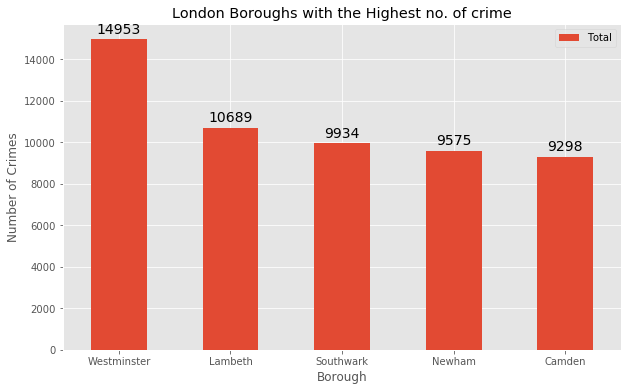

In [50]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [51]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,0,1,3,0,3,40,10,57
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,252,339,209,72,32,1039,1022,2965
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,400,417,160,78,45,1136,1142,3378
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,410,410,89,74,37,1529,974,3523
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,450,477,155,83,81,1476,1247,3969


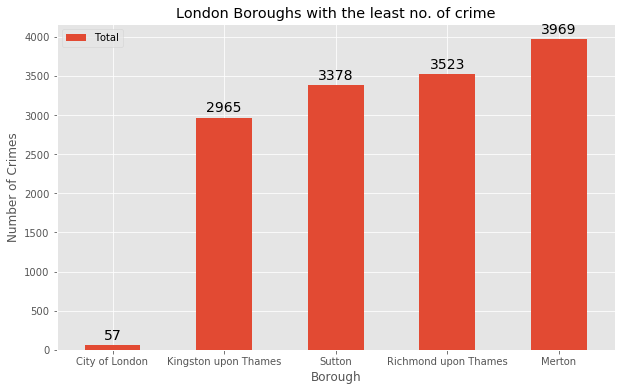

In [52]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [53]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,57,1.12,7000


<h4>As per the wikipedia page, The City of London is the 33rd principal division of Greater London but it is not a London borough.</h4>

URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

Hence we will focus on the next borough with the least crime i.e. Kingston upon Thames

Visualizing different types of crimes in the borough 'Kingston upon Thames'

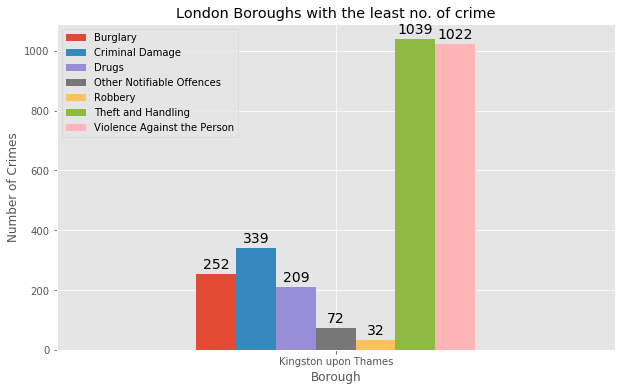

In [54]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

We can conclude that Kingston upon Thames is the safest borough when compared to the other boroughs in London.

<h3>Part 3: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.</h3>

The list of Neighborhoods in the Royal Borough of Kingston upon Thames was found on a wikipedia page: 

https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames

In [55]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


In [56]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [57]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


In [58]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


In [59]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

<h3>Modelling</h3>
<ul><li>Finding all the venues within a 500 meter radius of each neighborhood.</li>
    <li>Perform one hot ecoding on the venues data.</li>
    <li>Grouping the venues by the neighborhood and calculating their mean.</li>
    <li>Performing a K-means clustering (Defining K = 5)</li></ul>
    
<p>Create a function to extract the venues from each Neighborhood</p>

In [60]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [61]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [62]:
print(kut_venues.shape)
kut_venues.head()

(173, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Berrylands,51.393781,-0.284802,Rob Taylor's Ultimate Gay Sauna,51.390022,-0.284894,Sauna / Steam Room
4,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park


In [63]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,4,4,4,4,4,4
Canbury,14,14,14,14,14,14
Coombe,1,1,1,1,1,1
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,8,8,8,8,8,8


In [64]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 70 uniques categories.


<h4>One hot encoding</h4>
URL: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [65]:
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,Breakfast Spot,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,Breakfast Spot,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.071429,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Coombe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kingston upon Thames,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000
6,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,New Malden,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Norbiton,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,...,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037


In [67]:
kut_grouped.shape

(14, 71)

In [68]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0  Gym / Fitness Center  0.25
1    Sauna / Steam Room  0.25
2                  Park  0.25
3              Bus Stop  0.25
4                 Plaza  0.00


----Canbury----
               venue  freq
0                Pub  0.29
1     Shop & Service  0.07
2              Hotel  0.07
3  Indian Restaurant  0.07
4  Fish & Chips Shop  0.07


----Coombe----
               venue  freq
0           Tea Room   1.0
1   Asian Restaurant   0.0
2  Korean Restaurant   0.0
3        Pizza Place   0.0
4           Pharmacy   0.0


----Hook----
               venue  freq
0      Grocery Store  0.25
1             Bakery  0.25
2  Indian Restaurant  0.25
3  Fish & Chips Shop  0.25
4             Market  0.00


----Kingston Vale----
            venue  freq
0   Grocery Store  0.25
1    Soccer Field  0.25
2             Bar  0.25
3  Sandwich Place  0.25
4     Pizza Place  0.00


----Kingston upon Thames----
              venue  freq
0       Coffee Shop  0.10
1             

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [70]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Park,Gym / Fitness Center,Bus Stop,Sauna / Steam Room,Wine Shop,Farmers Market,Department Store,Discount Store,Dry Cleaner,Electronics Store
1,Canbury,Pub,Park,Café,Fish & Chips Shop,Supermarket,Spa,Shop & Service,Gym / Fitness Center,Plaza,Hotel
2,Coombe,Tea Room,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop
3,Hook,Indian Restaurant,Grocery Store,Bakery,Fish & Chips Shop,Food,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
4,Kingston Vale,Grocery Store,Bar,Soccer Field,Sandwich Place,Wine Shop,Fast Food Restaurant,Department Store,Discount Store,Dry Cleaner,Electronics Store


<h4>Clustering similar neighborhoods together using k - means clustering</h4>

In [71]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 3, 0, 4, 0, 2, 1, 0, 0], dtype=int32)

In [72]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,1.0,Park,Gym / Fitness Center,Bus Stop,Sauna / Steam Room,Wine Shop,Farmers Market,Department Store,Discount Store,Dry Cleaner,Electronics Store
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0.0,Pub,Park,Café,Fish & Chips Shop,Supermarket,Spa,Shop & Service,Gym / Fitness Center,Plaza,Hotel
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,3.0,Tea Room,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop
4,Hook,Kingston upon Thames,51.367898,-0.307145,0.0,Indian Restaurant,Grocery Store,Bakery,Fish & Chips Shop,Food,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant


In [73]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          14 non-null     float64
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

In [74]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [75]:
kut_merged.shape

(14, 15)

In [76]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [77]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            14 non-null     object 
 1   Borough                 14 non-null     object 
 2   Latitude                14 non-null     float64
 3   Longitude               14 non-null     float64
 4   Cluster Labels          14 non-null     int64  
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

<h3>Visualize the Clusters</h3>

In [78]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Each cluster is color coded for the ease of presentation, we can see that majority of the neighborhood falls in the red cluster which is the first cluster. Three neighborhoods have their own cluster (Blue, Purple and Yellow), these are clusters two three and five. The green cluster consists of two neighborhoods which is the 4th cluster.

<h3>Analysis</h3>
Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

<h5>Examine the first cluster</h5>

In [79]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0,Pub,Park,Café,Fish & Chips Shop,Supermarket,Spa,Shop & Service,Gym / Fitness Center,Plaza,Hotel
4,Hook,Kingston upon Thames,51.367898,-0.307145,0,Indian Restaurant,Grocery Store,Bakery,Fish & Chips Shop,Food,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,0,Coffee Shop,Café,Burger Joint,Sushi Restaurant,Pub,Record Shop,Cosmetics Shop,Electronics Store,Market,Mexican Restaurant
9,New Malden,Kingston upon Thames,51.405335,-0.263407,0,Gastropub,Bar,Sushi Restaurant,Supermarket,Gym,Chinese Restaurant,Korean Restaurant,Indian Restaurant,Wine Shop,Farmers Market
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,0,Pub,Indian Restaurant,Italian Restaurant,Food,Wine Shop,Fried Chicken Joint,Farmers Market,Dry Cleaner,Grocery Store,Hardware Store
11,Old Malden,Kingston upon Thames,51.382484,-0.259090,0,Train Station,Construction & Landscaping,Pub,Food,Fast Food Restaurant,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,0,Indian Restaurant,Coffee Shop,Pub,Café,Hotel,Chinese Restaurant,Italian Restaurant,Restaurant,Golf Course,Harbor / Marina
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,0,Coffee Shop,Pub,Pharmacy,Grocery Store,Breakfast Spot,Hotel,French Restaurant,Pizza Place,Platform,Gym / Fitness Center
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,0,Grocery Store,Restaurant,Pharmacy,Italian Restaurant,Discount Store,Coffee Shop,Furniture / Home Store,Pizza Place,Hotel,Café


In [80]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,1,Park,Gym / Fitness Center,Bus Stop,Sauna / Steam Room,Wine Shop,Farmers Market,Department Store,Discount Store,Dry Cleaner,Electronics Store
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,1,Gym,Park,Soccer Field,Bus Stop,Wine Shop,Farmers Market,Department Store,Discount Store,Dry Cleaner,Electronics Store


In [81]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,2,Garden Center,Pub,Restaurant,Convenience Store,Wine Shop,Electronics Store,Deli / Bodega,Department Store,Discount Store,Dry Cleaner


In [82]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.41945,-0.265398,3,Tea Room,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fish & Chips Shop


In [83]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.43185,-0.258138,4,Grocery Store,Bar,Soccer Field,Sandwich Place,Wine Shop,Fast Food Restaurant,Department Store,Discount Store,Dry Cleaner,Electronics Store


The fifth cluster has one neighborhood which consists of Venues such as Grocery shops, Bars, Restaurants, Furniture shops, and Department stores.

<h3>Results and Discussion</h3> 
The aim of this project is to help people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable. For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family.

<h3>Conclusion</h3> 
This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget.